#### Importing libs:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook as tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

import pickle
import random
import warnings
warnings.filterwarnings('ignore')

#### Reading dataset

In [2]:
filename = 'unbalaced_20_80_dataset.csv'

data = pd.read_csv(filename, index_col=False)
# data = pd.read_csv(filename, index_col=False, nrows=10000)
print('Dataframe shape',data.shape)
data.head()

Dataframe shape (7616509, 85)


,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1739476,172.31.69.25-18.219.193.20-80-37882-6,18.219.193.20,37882,172.31.69.25,80,6,16/02/2018 11:27:29 PM,8660,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,1822666,172.31.69.28-18.219.9.1-80-63287-6,172.31.69.28,80,18.219.9.1,63287,6,22/02/2018 12:13:52 AM,5829,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,905739,172.31.69.28-52.14.136.135-80-63095-6,52.14.136.135,63095,172.31.69.28,80,6,22/02/2018 12:14:02 AM,3396,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,1143064,172.31.69.28-18.216.200.189-80-52341-6,18.216.200.189,52341,172.31.69.28,80,6,22/02/2018 12:28:04 AM,2390,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,1934016,172.31.69.28-18.218.55.126-80-57459-6,172.31.69.28,80,18.218.55.126,57459,6,22/02/2018 12:19:45 AM,17362,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


#### Checking which columns contain nan or infinite values:

In [3]:
nan_col = data.columns[data.isna().any()].tolist()
print('Columns with null values:\n',nan_col,'\n')

infinity = [np.inf, -np.inf]
inf_columns = []
for col in tqdm(data.columns):
    if data[col].isin(infinity).any():
        inf_columns.append(col)
print('\n Columns with inf or -inf values:\n',inf_columns,'\n')

Columns with null values:
 ['Flow Byts/s'] 





 Columns with inf or -inf values:
 ['Flow Byts/s', 'Flow Pkts/s'] 



#### Replacing inf with nan first, then we will replace all nan values with mean of the column:

In [4]:
data.replace([np.inf, -np.inf], np.nan,inplace=True)

#### Filling all the remaining missing values by mean

In [5]:
print('Filling \'Flow Pkts/s\' nan values with mean :',data['Flow Pkts/s'].mean())
print('Filling \'Flow Byts/s\' nan values with mean :',data['Flow Byts/s'].mean())

data['Flow Byts/s'].fillna(data['Flow Byts/s'].mean(),inplace=True)
data['Flow Pkts/s'].fillna(data['Flow Pkts/s'].mean(),inplace=True)
# data.dropna(axis=0, how='any',inplace=True)

Filling 'Flow Pkts/s' nan values with mean : 33400.4598157847
Filling 'Flow Byts/s' nan values with mean : 330590.4234238568


#### Single valued and categorical features:

In [6]:
drop_lst = []
catfeat = []
for col in tqdm(data.columns):
    if len(data[col].unique())==1:
        drop_lst.append(col)
    elif len(data[col].unique())<=2:
        catfeat.append(col)

catfeat.append('y')     
print('Columns with single value:\n',np.array(drop_lst),'\n')
print('Categorical columns:\n',np.array(catfeat),'\n')


Columns with single value:
 ['Fwd URG Flags' 'Bwd URG Flags' 'Fwd Byts/b Avg' 'Fwd Pkts/b Avg'
 'Fwd Blk Rate Avg' 'Bwd Byts/b Avg' 'Bwd Pkts/b Avg' 'Bwd Blk Rate Avg'] 

Categorical columns:
 ['Fwd PSH Flags' 'Bwd PSH Flags' 'FIN Flag Cnt' 'SYN Flag Cnt'
 'RST Flag Cnt' 'PSH Flag Cnt' 'ACK Flag Cnt' 'URG Flag Cnt'
 'CWE Flag Count' 'ECE Flag Cnt' 'Label' 'y'] 



### Trimming columns which are not required:

<ul>
    <li>Looking at the data above, We can drop flow id because it is just combination of: 
        <ul>
            <li>'Src IP'</li>
            <li>'Dst IP'</li>
            <li>'Src Port'</li>
            <li>'Dst Port'</li>
            <li>'Protocol'.</li>
        </ul>
    <li>'Label' is our target column</li>
    <li>Dropping 'Timestamp' and 'Unnamed: 0' columns.</li>
    <li>Dropping columns with single value:</li>
    <ul>
        <li>'Fwd URG Flags'</li> 
        <li>'Bwd URG Flags'</li> 
        <li>'Fwd Byts/b Avg'</li> 
        <li>'Fwd Pkts/b Avg'</li>
        <li>'Fwd Blk Rate Avg'</li> 
        <li>'Bwd Byts/b Avg'</li> 
        <li>'Bwd Pkts/b Avg'</li> 
        <li>'Bwd Blk Rate Avg']</li>
    </ul>
    <li>Src IP and Dst IP columns needs to be converted to numerical features</li>
</ul>


In [7]:
print('Dataframe shape before trimming:',data.shape)
# final_data = data
drop_lst.extend(['Label','Flow ID','Timestamp','Unnamed: 0'])
print('\nDropping following columns:\n',np.array(drop_lst))
final_data = data.drop(drop_lst,axis=1)
print('\nDataframe shape after trimming:',final_data.shape)

Dataframe shape before trimming: (7616509, 85)

Dropping following columns:
 ['Fwd URG Flags' 'Bwd URG Flags' 'Fwd Byts/b Avg' 'Fwd Pkts/b Avg'
 'Fwd Blk Rate Avg' 'Bwd Byts/b Avg' 'Bwd Pkts/b Avg' 'Bwd Blk Rate Avg'
 'Label' 'Flow ID' 'Timestamp' 'Unnamed: 0']

Dataframe shape after trimming: (7616509, 73)


### Feature Engineering 'Src IP' & 'Dst IP'
For Ex:
<ul>
<li>172.31.69.25 &nbsp => 172316925</li>
<li>18.219.193.20 => 1821919320</li>
</ul>

In [8]:
import warnings
warnings.filterwarnings('ignore')
tqdm().pandas()

Y = data['Label']
final_data['y'] = data['Label'].progress_apply(lambda x: 1 if x=='ddos' else 0)
# timestamp = final_data['Timestamp']

final_data['Src IP'] = data['Src IP'].progress_apply(lambda x: int(('').join(x.split('.'))))
final_data['Dst IP'] = data['Dst IP'].progress_apply(lambda x: int(('').join(x.split('.'))))

In [9]:
print('\nFinal data shape:', final_data.shape)
final_data.head()


Final data shape: (7616509, 74)


,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,y
0,1821919320,37882,172316925,80,6,8660,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,172316928,80,1821991,63287,6,5829,4,3,935.0,298.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,5214136135,63095,172316928,80,6,3396,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,18216200189,52341,172316928,80,6,2390,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,172316928,80,1821855126,57459,6,17362,4,3,935.0,314.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


#### Separating Non-Categorical columns for data Normalization:

In [10]:
lst = [i for i in final_data.columns if i not in catfeat]
print(len(lst))
print(np.array(lst))

63
['Src IP' 'Src Port' 'Dst IP' 'Dst Port' 'Protocol' 'Flow Duration'
 'Tot Fwd Pkts' 'Tot Bwd Pkts' 'TotLen Fwd Pkts' 'TotLen Bwd Pkts'
 'Fwd Pkt Len Max' 'Fwd Pkt Len Min' 'Fwd Pkt Len Mean' 'Fwd Pkt Len Std'
 'Bwd Pkt Len Max' 'Bwd Pkt Len Min' 'Bwd Pkt Len Mean' 'Bwd Pkt Len Std'
 'Flow Byts/s' 'Flow Pkts/s' 'Flow IAT Mean' 'Flow IAT Std' 'Flow IAT Max'
 'Flow IAT Min' 'Fwd IAT Tot' 'Fwd IAT Mean' 'Fwd IAT Std' 'Fwd IAT Max'
 'Fwd IAT Min' 'Bwd IAT Tot' 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Max'
 'Bwd IAT Min' 'Fwd Header Len' 'Bwd Header Len' 'Fwd Pkts/s' 'Bwd Pkts/s'
 'Pkt Len Min' 'Pkt Len Max' 'Pkt Len Mean' 'Pkt Len Std' 'Pkt Len Var'
 'Down/Up Ratio' 'Pkt Size Avg' 'Fwd Seg Size Avg' 'Bwd Seg Size Avg'
 'Subflow Fwd Pkts' 'Subflow Fwd Byts' 'Subflow Bwd Pkts'
 'Subflow Bwd Byts' 'Init Fwd Win Byts' 'Init Bwd Win Byts'
 'Fwd Act Data Pkts' 'Fwd Seg Size Min' 'Active Mean' 'Active Std'
 'Active Max' 'Active Min' 'Idle Mean' 'Idle Std' 'Idle Max' 'Idle Min']


#### Splitting train and test:

In [11]:
label = final_data['y']
X_train, X_test, y_train, y_test = train_test_split(final_data.drop(['y'],axis=1),label,test_size=0.2,random_state=42,stratify=label)
print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)
print('y_train shape:',y_train.shape)
print('y_test shape:',y_test.shape)

X_train shape: (6093207, 73)
X_test shape: (1523302, 73)
y_train shape: (6093207,)
y_test shape: (1523302,)


#### Data Normalisation:

In [12]:
for i in tqdm(lst):
    minimum = X_train[i].min()
    maximum = X_train[i].max()
    X_train[i] = (X_train[i] - minimum)/(maximum - minimum)
    X_test[i] = (X_test[i] - minimum)/(maximum - minimum)

In [13]:
X_train.head()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
1994346,0.007718,0.753155,0.663078,0.001221,0.352941,0.458127,0.000008,0.000000,0.000000,0.000000e+00,...,0.0,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5837974,0.000772,0.990326,0.000007,0.000809,1.000000,0.000006,0.000004,0.000003,0.000005,1.045241e-07,...,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1396364,0.000028,0.750896,0.006751,0.006790,0.352941,0.000866,0.000012,0.000003,0.000000,0.000000e+00,...,0.0,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2540111,0.000772,0.788968,0.000007,0.000809,1.000000,0.000008,0.000004,0.000003,0.000004,3.010917e-07,...,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5945010,0.007718,0.762341,0.009087,0.001221,0.352941,0.000039,0.000008,0.000000,0.000000,0.000000e+00,...,0.0,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### For memory optimization lets free memory for final_data dataframe:

In [14]:
del final_data

### Cross-validation function:
<font size=4>We will use this function to check performances of our models against different test sets for more accurate f1 and macro_f1 score.</font>

In [15]:
def cross_validation(mod):
    print('calling cross_val_score with cv=5 for test data:')
    scoring = ['f1', 'f1_macro']
    scores = cross_validate(mod, X_test, y_test, cv=5, scoring=scoring)
    return scores

## We will try various models listed below and will select the best one:
<font size=4>
<ol>
    <li>Logistic Regression</li>
    <li>Naive Bayes</li>
    <li>Random Forest</li>
    <li>Decision Tree</li>
    <li>XgBoost</li>
    <li>AdaBoost</li>
    <li>LSTM</li>
</ol>
</font>

## 1. LogicticRegression

In [15]:
params = {'C': [ 0.01, 0.1, 10, 100] }
x_clf_1 = LogisticRegression(n_jobs=-1)

random_clf_1 = RandomizedSearchCV(x_clf_1, param_distributions=params, scoring='f1', verbose=10, cv=2)
random_clf_1.fit(X_train,y_train)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.910, total= 5.0min
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.0min remaining:    0.0s


[CV] ............................. C=0.001, score=0.909, total= 5.2min
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.2min remaining:    0.0s


[CV] .............................. C=0.01, score=0.929, total=10.1min
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.3min remaining:    0.0s


[CV] .............................. C=0.01, score=0.928, total=10.1min
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 30.4min remaining:    0.0s


[CV] ............................... C=0.1, score=0.937, total= 9.9min
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 40.3min remaining:    0.0s


[CV] ............................... C=0.1, score=0.937, total=10.2min
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 50.5min remaining:    0.0s


[CV] ................................. C=1, score=0.966, total=10.3min
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 60.8min remaining:    0.0s


[CV] ................................. C=1, score=0.967, total=10.1min
[CV] C=10 ............................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 70.9min remaining:    0.0s


[CV] ................................ C=10, score=0.970, total=10.2min
[CV] C=10 ............................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 81.1min remaining:    0.0s


[CV] ................................ C=10, score=0.970, total=10.1min
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.970, total=10.6min
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.971, total=10.8min
[CV] C=1000 ..........................................................
[CV] .............................. C=1000, score=0.969, total=10.4min
[CV] C=1000 ..........................................................
[CV] .............................. C=1000, score=0.970, total=10.0min


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 133.0min finished


RandomizedSearchCV(cv=2, estimator=LogisticRegression(n_jobs=-1),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000]},
                   scoring='f1', verbose=10)

In [16]:
print(random_clf_1.best_params_)
print(random_clf_1.best_score_)

{'C': 100}
0.9701642544982462


In [17]:
%%time

model1 = LogisticRegression(C=random_clf_1.best_params_['C'], penalty='l2', random_state=42, n_jobs=-1, verbose=1)
model1.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: user 3.05 s, sys: 3.64 s, total: 6.69 s
Wall time: 20min


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 19.9min finished


LogisticRegression(C=100, n_jobs=-1, random_state=42, verbose=1)

In [18]:
ypred = model1.predict(X_train)
# print(ypred)
f1score = f1_score(y_train, np.round(ypred))
print('f1_score for train:',f1score)

ypred = model1.predict(X_test)
f1score = f1_score(y_test, np.round(ypred))
print('f1_score for test:',f1score)

# Dumping model in pickle file
with open('LR.pkl', 'wb') as fp:
    pickle.dump(model1, fp, protocol=pickle.HIGHEST_PROTOCOL)

f1_score for train: 0.9693938504898542
f1_score for test: 0.969580030125639


#### Cross-Validated f1 and macro_f1 test scores:

In [38]:
%%time

infile = open('LR.pkl','rb')
model = pickle.load(infile)
infile.close()

scores = cross_validation(model)
print(scores)

calling cross_val_score with cv=5 for test data:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.1min finished


{'fit_time': array([247.16897297, 250.42288804, 259.1509254 , 249.28245568,
       247.58299446]), 'score_time': array([0.32475019, 0.30092549, 0.31641674, 0.30802679, 0.31410551]), 'test_f1': array([0.96844455, 0.97006138, 0.97029855, 0.97028939, 0.96724908]), 'test_f1_macro': array([0.98097718, 0.98195776, 0.98209756, 0.98209675, 0.9802568 ])}
CPU times: user 7.42 s, sys: 7.41 s, total: 14.8 s
Wall time: 20min 55s


In [40]:
print('mean test f1_score: ',scores['test_f1'].mean())
print('mean test macro_f1: ',scores['test_f1_macro'].mean())

mean test f1_score:  0.9692685905523243
mean test macro_f1:  0.9814772089338742


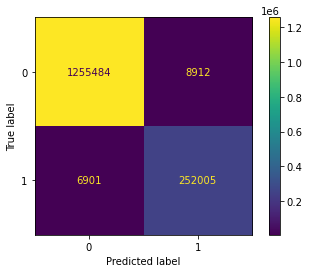

In [19]:
plot_confusion_matrix(model1, X_test, y_test, values_format='')
plt.show()

## 2. Naive Bayes

var_smoothing parameter's default value is  10^−9 . We will conduct the random search in the "logspace", that is, we will search over the powers of 10. We will start with  10^0  and end with  10^−9  and we will try 10 different values. For this search, we will use the logspace function in the numpy module.

In [20]:
%%time

var = np.logspace(0,-9, num=10)
print(var)
np.random.seed(999)
params = {'var_smoothing': var}

x_clf_2 = GaussianNB()
random_clf_2 = RandomizedSearchCV(x_clf_2, param_distributions=params, scoring='f1', verbose=10, cv=2)
random_clf_2.fit(X_train,y_train)

[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09]
Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] var_smoothing=1.0 ...............................................
[CV] ................... var_smoothing=1.0, score=0.689, total=  11.3s
[CV] var_smoothing=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s


[CV] ................... var_smoothing=1.0, score=0.689, total=  11.0s
[CV] var_smoothing=0.1 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.3s remaining:    0.0s


[CV] ................... var_smoothing=0.1, score=0.738, total=  11.3s
[CV] var_smoothing=0.1 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.6s remaining:    0.0s


[CV] ................... var_smoothing=0.1, score=0.738, total=  11.0s
[CV] var_smoothing=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   44.6s remaining:    0.0s


[CV] .................. var_smoothing=0.01, score=0.749, total=  11.2s
[CV] var_smoothing=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.8s remaining:    0.0s


[CV] .................. var_smoothing=0.01, score=0.747, total=  11.1s
[CV] var_smoothing=0.001 .............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s


[CV] ................. var_smoothing=0.001, score=0.666, total=  11.2s
[CV] var_smoothing=0.001 .............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV] ................. var_smoothing=0.001, score=0.662, total=  11.0s
[CV] var_smoothing=0.0001 ............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV] ................ var_smoothing=0.0001, score=0.656, total=  11.3s
[CV] var_smoothing=0.0001 ............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV] ................ var_smoothing=0.0001, score=0.654, total=  11.5s
[CV] var_smoothing=1e-05 .............................................
[CV] ................. var_smoothing=1e-05, score=0.646, total=  11.4s
[CV] var_smoothing=1e-05 .............................................
[CV] ................. var_smoothing=1e-05, score=0.644, total=  11.0s
[CV] var_smoothing=1e-06 .............................................
[CV] ................. var_smoothing=1e-06, score=0.638, total=  11.1s
[CV] var_smoothing=1e-06 .............................................
[CV] ................. var_smoothing=1e-06, score=0.640, total=  11.4s
[CV] var_smoothing=1e-07 .............................................
[CV] ................. var_smoothing=1e-07, score=0.630, total=  11.3s
[CV] var_smoothing=1e-07 .............................................
[CV] ................. var_smoothing=1e-07, score=0.632, total=  11.1s
[CV] var_smoothing=1e-08 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.7min finished


CPU times: user 2min 43s, sys: 1min 10s, total: 3min 53s
Wall time: 3min 53s


RandomizedSearchCV(cv=2, estimator=GaussianNB(),
                   param_distributions={'var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
                   scoring='f1', verbose=10)

In [21]:
%%time

model2 = GaussianNB(var_smoothing=random_clf_2.best_params_['var_smoothing'])
model2.fit(X_train,y_train)

CPU times: user 6.96 s, sys: 2.53 s, total: 9.49 s
Wall time: 9.49 s


GaussianNB(var_smoothing=0.01)

In [22]:
ypred = model2.predict(X_train)
f1score = f1_score(y_train, ypred)
print('f1_score for train:',f1score)

ypred = model2.predict(X_test)
f1score = f1_score(y_test, ypred)
print('f1_score for test:',f1score)

# Dumping model in pickle file
with open('NB.pkl', 'wb') as fp:
    pickle.dump(model2, fp, protocol=pickle.HIGHEST_PROTOCOL)

f1_score for train: 0.7479796125342537
f1_score for test: 0.7474012310537557


#### Cross-Validated f1 and macro_f1 test scores:

In [41]:
%%time

infile = open('NB.pkl','rb')
model = pickle.load(infile)
infile.close()

scores = cross_validation(model)
print(scores)

calling cross_val_score with cv=5 for test data:
{'fit_time': array([2.12994885, 2.08233976, 2.08665562, 2.0582931 , 2.05784059]), 'score_time': array([0.53161454, 0.49161148, 0.49541712, 0.50018883, 0.48911643]), 'test_f1': array([0.74950168, 0.74823826, 0.74855166, 0.7479548 , 0.74662605]), 'test_f1_macro': array([0.84179548, 0.84097184, 0.84121444, 0.84079266, 0.83983113])}
CPU times: user 9.94 s, sys: 3.22 s, total: 13.2 s
Wall time: 13.2 s


In [42]:
print('mean test f1_score: ',scores['test_f1'].mean())
print('mean test macro_f1: ',scores['test_f1_macro'].mean())

mean test f1_score:  0.7481744904052343
mean test macro_f1:  0.8409211100974849


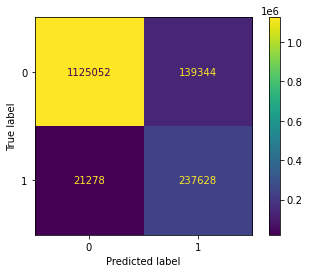

In [23]:
plot_confusion_matrix(model2, X_test, y_test, values_format='')
plt.show()

## 3. Decision Tree

In [29]:
%%time
from scipy.stats import randint

params = {'max_depth' : [3,5,8,None],
         'max_features': ['auto','log2',None],
         }
x_clf_5 = DecisionTreeClassifier()

random_clf_5 = RandomizedSearchCV(x_clf_5, param_distributions=params, scoring='f1', verbose=1, cv=2, n_jobs=3)
random_clf_5.fit(X_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  4.6min finished


CPU times: user 7min 51s, sys: 3.1 s, total: 7min 55s
Wall time: 12min 28s


RandomizedSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_jobs=3,
                   param_distributions={'max_depth': [3, 5, 8, None],
                                        'max_features': ['auto', 'log2', None]},
                   scoring='f1', verbose=1)

In [30]:
print(random_clf_5.best_params_)
print(random_clf_5.best_score_)

{'max_features': None, 'max_depth': None}
0.9998179898397053


In [36]:
%%time

model5 = DecisionTreeClassifier(max_depth=None, max_features=None)
model5.fit(X_train,y_train)

CPU times: user 7min 52s, sys: 888 ms, total: 7min 52s
Wall time: 7min 53s


DecisionTreeClassifier()

In [37]:
ypred = model5.predict(X_train)
f1score = f1_score(y_train, np.round(ypred))
print('f1_score for train:',f1score)

ypred = model5.predict(X_test)
f1score = f1_score(y_test, np.round(ypred))
print('f1_score for test:',f1score)

# Dumping model in pickle file
with open('DT.pkl', 'wb') as fp:
    pickle.dump(model5, fp, protocol=pickle.HIGHEST_PROTOCOL)

f1_score for train: 1.0
f1_score for test: 0.9999111677577583


#### Cross-Validated f1 and macro_f1 test scores:

In [43]:
%%time

infile = open('DT.pkl','rb')
model = pickle.load(infile)
infile.close()

scores = cross_validation(model)
print(scores)

calling cross_val_score with cv=5 for test data:
{'fit_time': array([51.94898295, 55.84655428, 49.10616398, 49.56655407, 55.62586689]), 'score_time': array([0.28568459, 0.28620553, 0.27283049, 0.28904986, 0.27636051]), 'test_f1': array([0.99966207, 0.99967174, 0.99978759, 0.99974897, 0.99979723]), 'test_f1_macro': array([0.99979643, 0.99980226, 0.99987204, 0.99984878, 0.99987785])}
CPU times: user 4min 22s, sys: 1.19 s, total: 4min 23s
Wall time: 4min 23s


In [44]:
print('mean test f1_score: ',scores['test_f1'].mean())
print('mean test macro_f1: ',scores['test_f1_macro'].mean())

mean test f1_score:  0.9997335201282768
mean test macro_f1:  0.9998394737718715


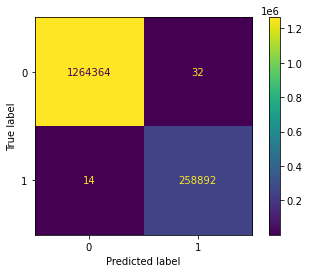

In [38]:
plot_confusion_matrix(model5, X_test, y_test, values_format='')
plt.show()

## 4. Random Forest 

In [39]:
%%time
params={'n_estimators' : [100,200,300,500,800],
       'max_depth' : [10,20,40,60,80]
       }

x_clf_4 = RandomForestClassifier()

random_clf_4 = RandomizedSearchCV(x_clf_4, param_distributions=params, scoring='f1', verbose=1, cv=2, n_jobs=3)
random_clf_4.fit(X_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed: 338.1min finished


CPU times: user 3h 2min 12s, sys: 4.15 s, total: 3h 2min 17s
Wall time: 8h 40min 17s


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=3,
                   param_distributions={'max_depth': [10, 20, 40, 60, 80],
                                        'n_estimators': [100, 200, 300, 500,
                                                         800]},
                   scoring='f1', verbose=1)

In [40]:
print(random_clf_4.best_params_)
print(random_clf_4.best_score_)

{'n_estimators': 500, 'max_depth': 40}
0.9999526835091561


In [43]:
%%time

model4 = RandomForestClassifier(n_estimators=random_clf_4.best_params_['n_estimators'], max_depth=random_clf_4.best_params_['max_depth'], 
                                random_state=42, n_jobs=-1, verbose=1)
model4.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 24.3min


CPU times: user 3h 38min 30s, sys: 1min 39s, total: 3h 40min 9s
Wall time: 28min


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 28.0min finished


RandomForestClassifier(max_depth=40, n_estimators=500, n_jobs=-1,
                       random_state=42, verbose=1)

In [44]:
ypred = model4.predict(X_train)
f1score = f1_score(y_train, np.round(ypred))
print('f1_score for train:',f1score)

ypred = model4.predict(X_test)
f1score = f1_score(y_test, np.round(ypred))
print('f1_score for test:',f1score)

# Dumping model in pickle file
with open('RF.pkl', 'wb') as fp:
    pickle.dump(model4, fp, protocol=pickle.HIGHEST_PROTOCOL)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   24.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   56.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.1min finished


f1_score for train: 1.0


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   15.3s finished


f1_score for test: 0.9999787563996347


#### Cross-Validated f1 and macro_f1 test scores:

In [45]:
%%time

infile = open('RF.pkl','rb')
model = pickle.load(infile)
infile.close()

scores = cross_validation(model)
print(scores)

calling cross_val_score with cv=5 for test data:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.8min finished
[

{'fit_time': array([285.87238193, 286.32101226, 291.65386677, 289.57515574,
       286.91730094]), 'score_time': array([3.10242677, 3.07567286, 3.07413435, 2.9816103 , 2.96468186]), 'test_f1': array([0.99985514, 0.9998648 , 0.99988412, 0.99989377, 0.99994206]), 'test_f1_macro': array([0.99991274, 0.99991856, 0.99993019, 0.99993601, 0.9999651 ])}
CPU times: user 1min 57s, sys: 4.16 s, total: 2min 1s
Wall time: 24min 16s


In [46]:
print('mean test f1_score: ',scores['test_f1'].mean())
print('mean test macro_f1: ',scores['test_f1_macro'].mean())

mean test f1_score:  0.9998879787998447
mean test macro_f1:  0.9999325217179905


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   15.3s finished


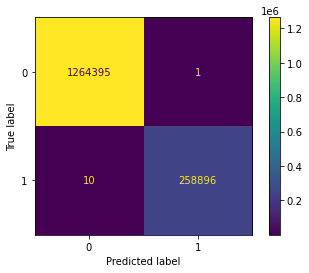

In [45]:
plot_confusion_matrix(model4, X_test, y_test, values_format='')
plt.show()

## 5. XGBoost

In [46]:
%%time
# Hyperparameter tunning
x_clf_6 = XGBClassifier(n_jobs=-1)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

random_clf_6 = RandomizedSearchCV(x_clf_6,param_distributions=params,verbose=10,cv=2,n_jobs=3)
random_clf_6.fit(X_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed: 26.0min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 66.2min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 90.7min
[Parallel(n_jobs=3)]: Done  18 out of  20 | elapsed: 137.0min remaining: 15.2min
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed: 153.3min finished


[05:00:44] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 1h 11min 6s, sys: 6.15 s, total: 1h 11min 12s
Wall time: 3h 42min 28s


RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                            

In [47]:
print(random_clf_6.best_params_)
print(random_clf_6.best_score_)

{'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 1, 'colsample_bytree': 0.6}
0.9999993435312471


In [48]:
%%time

model6 = XGBClassifier(max_depth=random_clf_6.best_params_['max_depth'], subsample=random_clf_6.best_params_['subsample'], 
                       colsample_bytree=random_clf_6.best_params_['colsample_bytree'], min_child_weight=random_clf_6.best_params_['min_child_weight'], 
                       gamma=random_clf_6.best_params_['gamma'],n_jobs=-1)
model6.fit(X_train,y_train, verbose=10)

[06:09:39] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 56min 43s, sys: 3.54 s, total: 56min 47s
Wall time: 56min 47s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='approx', validate_parameters=1, verbosity=None)

In [49]:
ypred = model6.predict(X_train)
print(ypred)
f1score = f1_score(y_train, np.round(ypred))
print('f1_score for train:',f1score)

ypred = model6.predict(X_test)
f1score = f1_score(y_test, np.round(ypred))
print('f1_score for test:',f1score)

# Dumping model in pickle file
with open('XGB.pkl', 'wb') as fp:
    pickle.dump(model6, fp, protocol=pickle.HIGHEST_PROTOCOL)

[0 0 0 ... 0 0 0]
f1_score for train: 0.9999995171990593
f1_score for test: 0.9999922752483507


#### Cross-Validated f1 and macro_f1 test scores:

In [47]:
%%time

infile = open('XGB.pkl','rb')
model = pickle.load(infile)
infile.close()

scores = cross_validation(model)
print(scores)

calling cross_val_score with cv=5 for test data:
{'fit_time': array([540.55194044, 554.16048884, 644.94158578, 649.97757339,
       642.94089556]), 'score_time': array([1.27535868, 1.30193949, 1.30245042, 1.29370308, 1.26659322]), 'test_f1': array([0.99996138, 0.99999034, 0.99999034, 1.        , 0.99997103]), 'test_f1_macro': array([0.99997673, 0.99999418, 0.99999418, 1.        , 0.99998255])}
CPU times: user 50min 35s, sys: 3.75 s, total: 50min 39s
Wall time: 50min 39s


In [48]:
print('mean test f1_score: ',scores['test_f1'].mean())
print('mean test macro_f1: ',scores['test_f1_macro'].mean())

mean test f1_score:  0.9999826191633285
mean test macro_f1:  0.9999895300772058


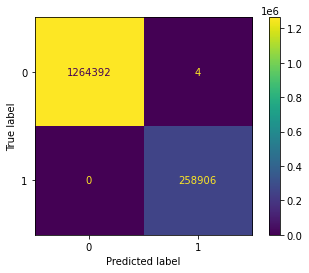

In [50]:
plot_confusion_matrix(model6, X_test, y_test, values_format='')
plt.show()

## 6. AdaBoostClassifier

In [17]:
x_clf_7 = AdaBoostClassifier()
params = {'n_estimators' : [100,200,300,500,800] }

random_clf_7 = RandomizedSearchCV(x_clf_7,param_distributions=params,verbose=10,cv=2,n_jobs=3)
random_clf_7.fit(X_train,y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed: 26.5min
[Parallel(n_jobs=3)]: Done   7 out of  10 | elapsed: 193.7min remaining: 83.0min
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 382.6min finished


RandomizedSearchCV(cv=2, estimator=AdaBoostClassifier(), n_jobs=3,
                   param_distributions={'n_estimators': [100, 200, 300, 500,
                                                         800]},
                   verbose=10)

In [18]:
print(random_clf_7.best_params_)
print(random_clf_7.best_score_)

{'n_estimators': 800}
0.9999978664767957


In [16]:
%%time

model7 = AdaBoostClassifier(n_estimators=800)
model7.fit(X_train,y_train)

CPU times: user 5h 54min 32s, sys: 8min 12s, total: 6h 2min 44s
Wall time: 6h 2min 47s


AdaBoostClassifier(n_estimators=800)

In [17]:
ypred = model7.predict(X_train)
print(ypred)
f1score = f1_score(y_train, np.round(ypred))
print('f1_score for train:',f1score)

ypred = model7.predict(X_test)
f1score = f1_score(y_test, np.round(ypred))
print('f1_score for test:',f1score)

# Dumping model in pickle file
with open('ADB.pkl', 'wb') as fp:
    pickle.dump(model7, fp, protocol=pickle.HIGHEST_PROTOCOL)

[0 0 0 ... 0 0 0]
f1_score for train: 0.9999985515985764
f1_score for test: 1.0


#### Cross-Validated f1 and macro_f1 test scores:

In [18]:
%%time

infile = open('ADB.pkl','rb')
model = pickle.load(infile)
infile.close()

scores = cross_validation(model)
print(scores)

calling cross_val_score with cv=5 for test data:
{'fit_time': array([3623.53971577, 3618.99888182, 3612.57262778, 3751.86759043,
       3567.72887468]), 'score_time': array([52.92169356, 52.86364865, 53.49079776, 52.8428967 , 52.29335856]), 'test_f1': array([1.        , 0.99999034, 1.        , 0.99998069, 0.99999034]), 'test_f1_macro': array([1.        , 0.99999418, 1.        , 0.99998837, 0.99999418])}
CPU times: user 4h 59min 3s, sys: 8min 13s, total: 5h 7min 17s
Wall time: 5h 7min 19s


In [19]:
print('mean test f1_score: ',scores['test_f1'].mean())
print('mean test macro_f1: ',scores['test_f1_macro'].mean())

mean test f1_score:  0.999992275270726
mean test macro_f1:  0.9999953467417125


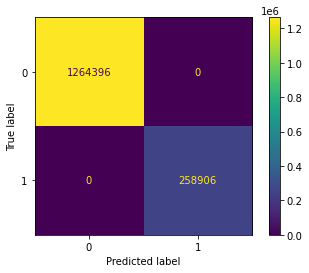

In [20]:
plot_confusion_matrix(model7, X_test, y_test, values_format='')
plt.show()

#### 7. Multi-layer Perceptron classifier
<font size=3>
    <ul>
<li>Lets try MLP Neural Network as well. Unlike other classification algorithms such as Logistic Regression or Naive Bayes Classifier, MLPClassifier relies on an underlying Neural Network to perform the task of classification.</li>
<li>'hidden_layer_sizes': Each element in the tuple represents the number of nodes at the ith position where i is the index of the tuple. Thus the length of tuple denotes the total number of hidden layers in the network.</li>
        </ul>
</font>

In [18]:
%%time

params = {
    'hidden_layer_sizes': [(74,74,50), (128,100,74)],
    'alpha': [0.0001, 0.05, 0.001],
}
x_clf_8 = MLPClassifier(n_iter_no_change=5)
                        
random_clf_8 = RandomizedSearchCV(x_clf_8,param_distributions=params,verbose=10,cv=2)
random_clf_8.fit(X_train,y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] hidden_layer_sizes=(74, 74, 50), alpha=0.0001 ...................
[CV]  hidden_layer_sizes=(74, 74, 50), alpha=0.0001, score=0.999, total=31.0min
[CV] hidden_layer_sizes=(74, 74, 50), alpha=0.0001 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 31.0min remaining:    0.0s


[CV]  hidden_layer_sizes=(74, 74, 50), alpha=0.0001, score=0.999, total=31.0min
[CV] hidden_layer_sizes=(128, 100, 74), alpha=0.0001 .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 61.9min remaining:    0.0s


[CV]  hidden_layer_sizes=(128, 100, 74), alpha=0.0001, score=0.999, total=43.6min
[CV] hidden_layer_sizes=(128, 100, 74), alpha=0.0001 .................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 105.5min remaining:    0.0s


[CV]  hidden_layer_sizes=(128, 100, 74), alpha=0.0001, score=1.000, total=44.1min
[CV] hidden_layer_sizes=(74, 74, 50), alpha=0.05 .....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 149.6min remaining:    0.0s


[CV]  hidden_layer_sizes=(74, 74, 50), alpha=0.05, score=0.997, total=30.6min
[CV] hidden_layer_sizes=(74, 74, 50), alpha=0.05 .....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 180.2min remaining:    0.0s


[CV]  hidden_layer_sizes=(74, 74, 50), alpha=0.05, score=0.997, total=25.9min
[CV] hidden_layer_sizes=(128, 100, 74), alpha=0.05 ...................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 206.1min remaining:    0.0s


[CV]  hidden_layer_sizes=(128, 100, 74), alpha=0.05, score=0.997, total=41.2min
[CV] hidden_layer_sizes=(128, 100, 74), alpha=0.05 ...................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 247.3min remaining:    0.0s


[CV]  hidden_layer_sizes=(128, 100, 74), alpha=0.05, score=0.997, total=49.6min
[CV] hidden_layer_sizes=(74, 74, 50), alpha=0.001 ....................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 296.9min remaining:    0.0s


[CV]  hidden_layer_sizes=(74, 74, 50), alpha=0.001, score=0.999, total=36.5min
[CV] hidden_layer_sizes=(74, 74, 50), alpha=0.001 ....................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 333.4min remaining:    0.0s


[CV]  hidden_layer_sizes=(74, 74, 50), alpha=0.001, score=0.999, total=41.0min
[CV] hidden_layer_sizes=(128, 100, 74), alpha=0.001 ..................
[CV]  hidden_layer_sizes=(128, 100, 74), alpha=0.001, score=0.999, total=48.1min
[CV] hidden_layer_sizes=(128, 100, 74), alpha=0.001 ..................
[CV]  hidden_layer_sizes=(128, 100, 74), alpha=0.001, score=0.999, total=44.1min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 466.5min finished


CPU times: user 1d 21h 13min 51s, sys: 1d 5h 4min 8s, total: 3d 2h 18min
Wall time: 9h 23min 29s


RandomizedSearchCV(cv=2, estimator=MLPClassifier(n_iter_no_change=5),
                   param_distributions={'alpha': [0.0001, 0.05, 0.001],
                                        'hidden_layer_sizes': [(74, 74, 50),
                                                               (128, 100, 74)]},
                   verbose=10)

In [19]:
print(random_clf_8.best_params_)
print(random_clf_8.best_score_)

{'hidden_layer_sizes': (128, 100, 74), 'alpha': 0.0001}
0.9994984578828068


In [16]:
%%time

model8 = MLPClassifier(hidden_layer_sizes=(128,100,74),
                       alpha=0.0001, verbose=True)
model8.fit(X_train,y_train)

Iteration 1, loss = 0.00768134
Iteration 2, loss = 0.00362890
Iteration 3, loss = 0.00318939
Iteration 4, loss = 0.00303354
Iteration 5, loss = 0.00284200
Iteration 6, loss = 0.00270759
Iteration 7, loss = 0.00261962
Iteration 8, loss = 0.00257533
Iteration 9, loss = 0.00251070
Iteration 10, loss = 0.00248885
Iteration 11, loss = 0.00245624
Iteration 12, loss = 0.00243178
Iteration 13, loss = 0.00240269
Iteration 14, loss = 0.00239845
Iteration 15, loss = 0.00236443
Iteration 16, loss = 0.00234827
Iteration 17, loss = 0.00235690
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
CPU times: user 10h 41min 16s, sys: 6h 40min 10s, total: 17h 21min 27s
Wall time: 2h 11min 23s


MLPClassifier(hidden_layer_sizes=(128, 100, 74), verbose=True)

In [17]:
ypred = model8.predict(X_train)
print(ypred)
f1score = f1_score(y_train, np.round(ypred))
print('f1_score for train:',f1score)
f1score = f1_score(y_train, np.round(ypred),average='macro')
print('macro f1_score for train:',f1score)
print('\n')

ypred = model8.predict(X_test)
f1score = f1_score(y_test, np.round(ypred))
print('f1_score for test:',f1score)
f1score = f1_score(y_test, np.round(ypred),average='macro')
print('macro f1_score for test:',f1score)

# Dumping model in pickle file
with open('MLP.pkl', 'wb') as fp:
    pickle.dump(model8, fp, protocol=pickle.HIGHEST_PROTOCOL)

[0 0 0 ... 0 0 0]
f1_score for train: 0.9988491398466388
macro f1_score for train: 0.9993066646448113


f1_score for test: 0.9988264813742521
macro f1_score for test: 0.9992930114923135


#### Cross-Validated f1 and macro_f1 test scores:

In [18]:
%%time

infile = open('MLP.pkl','rb')
model = pickle.load(infile)
infile.close()

scores = cross_validation(model)
print(scores)

calling cross_val_score with cv=5 for test data:
Iteration 1, loss = 0.01783954
Iteration 2, loss = 0.00707527
Iteration 3, loss = 0.00537857
Iteration 4, loss = 0.00436294
Iteration 5, loss = 0.00382851
Iteration 6, loss = 0.00358542
Iteration 7, loss = 0.00335249
Iteration 8, loss = 0.00319045
Iteration 9, loss = 0.00310788
Iteration 10, loss = 0.00292812
Iteration 11, loss = 0.00286882
Iteration 12, loss = 0.00286623
Iteration 13, loss = 0.00272831
Iteration 14, loss = 0.00274034
Iteration 15, loss = 0.00269739
Iteration 16, loss = 0.00260972
Iteration 17, loss = 0.00258210
Iteration 18, loss = 0.00256571
Iteration 19, loss = 0.00249917
Iteration 20, loss = 0.00253622
Iteration 21, loss = 0.00252892
Iteration 22, loss = 0.00249747
Iteration 23, loss = 0.00253269
Iteration 24, loss = 0.00246538
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.01555158
Iteration 2, loss = 0.00624352
Iteration 3, loss = 0.00484805
Iteration

In [19]:
print('mean test f1_score: ',scores['test_f1'].mean())
print('mean test macro_f1: ',scores['test_f1_macro'].mean())

mean test f1_score:  0.9985255070067225
mean test macro_f1:  0.9991116733667516


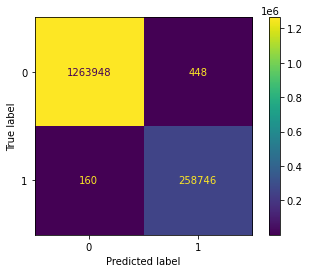

In [20]:
plot_confusion_matrix(model8, X_test, y_test, values_format='')
plt.show()

# Summary:

<font size=4>
Lets compare all the models:<br>
    <hr>
<\font>
<font size="4">
<table width="100%">
    <tr>
        <td width="5%"><b><font size="4">#</font></b></td>
        <td width="20%"><b><font size="4">Model</font></b></td>
        <td><b><font size="4">train f1</font></b></td>
        <td><b><font size="4">test f1</font></b></td>
        <td><b><font size="4">test macro_f1</font></b></td>
        <td><b><font size="4">TP</font></b></td>
        <td><b><font size="4">FP</font></b></td>
        <td><b><font size="4">FN</font></b></td>
        <td><b><font size="4">TN</font></b></td>
    </tr>
    <tr>
        <td><font size="4">1</font></td>
        <td><font size="4">LogisticRegression</font></td>
        <td><font size="4">0.96939385</font></td>
        <td><font size="4">0.96926859</font></td>
        <td><font size="4">0.98147721</font></td>
        <td><font size="4">1255484</font></td>
        <td><font size="4">8912</font></td>
        <td><font size="4">6901</font></td>
        <td><font size="4">252005</font></td>
    </tr>
    <tr>
        <td><font size="4">2</font></td>
        <td><font size="4">GaussianNB</font></td>
        <td><font size="4">0.74797961</font></td>
        <td><font size="4">0.74817449</font></td>
        <td><font size="4">0.84092111</font></td>
        <td><font size="4">1125052</font></td>
        <td><font size="4">139344</font></td>
        <td><font size="4">21278</font></td>
        <td><font size="4">237628</font></td>
    </tr>
    <tr>
        <td><font size="4">3</font></td>
        <td><font size="4">DecisionTreeClassifier</font></td>
        <td><font size="4">1.00000000</font></td>
        <td><font size="4">0.99973352</font></td>
        <td><font size="4">0.99983947</font></td>
        <td><font size="4">1264364</font></td>
        <td><font size="4">32</font></td>
        <td><font size="4">14</font></td>
        <td><font size="4">258892</font></td>
    </tr>
    <tr>
        <td><font size="4">4</font></td>
        <td><font size="4">RandomForestClassifier</font></td>
        <td><font size="4">1.00000000</font></td>
        <td><font size="4">0.99988798</font></td>
        <td><font size="4">0.99993252</font></td>
        <td><font size="4">1264395</font></td>
        <td><font size="4">1</font></td>
        <td><font size="4">10</font></td>
        <td><font size="4">258896</font></td>
    </tr>
    <tr>
        <td><font size="4">5</font></td>
        <td><font size="4">XGBoost</font></td>
        <td><font size="4">0.99999227</font></td>
        <td><font size="4">0.99998262</font></td>
        <td><font size="4">0.99998953</font></td>
        <td><font size="4">1264392</font></td>
        <td><font size="4">4</font></td>
        <td><font size="4">0</font></td>
        <td><font size="4">258906</font></td>
    </tr>
    <tr>
        <td><font size="4">6</font></td>
        <td><font size="4">AdaBoost</font></td>
        <td><font size="4">0.99999855</font></td>
        <td><font size="4">0.99999228</font></td>
        <td><font size="4">0.99999535</font></td>
        <td><font size="4">1264396</font></td>
        <td><font size="4">0</font></td>
        <td><font size="4">0</font></td>
        <td><font size="4">258906</font></td>
    </tr>
    <tr>
        <td><font size="4">7</font></td>
        <td><font size="4">MLPClassifier</font></td>
        <td><font size="4">0.99884914</font></td>
        <td><font size="4">0.99852551</font></td>
        <td><font size="4">0.99911167</font></td>
        <td><font size="4">1263958</font></td>
        <td><font size="4">448</font></td>
        <td><font size="4">160</font></td>
        <td><font size="4">258746</font></td>
    </tr>
</table>
</font>

## Finally, with AdaBoost we are getting almost 100% accurcay. <br>False Negative and False Positive both are zero which means that the AdaBoost model is able to detect DDoS attack from the Benign traffic with zero error.